In [1]:
# ipython settings
%load_ext autoreload
%autoreload 2

In [2]:
# imports
import sys
sys.path.append('../BioExp')
import keras
import numpy as np
import tensorflow as tf
from keras.models import load_model
import pandas as pd
import os
import pickle

from keras.backend.tensorflow_backend import set_session
from BioExp.helpers.metrics import *
from BioExp.helpers.losses import *

Using TensorFlow backend.
/home/parth/miniconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:523: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/home/parth/miniconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:524: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/home/parth/miniconda3/envs/dl/lib/python3.6/site-packages/tensorflow/python/framework/dtypes.py:525: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/home/parth/miniconda3/envs/dl/l

In [3]:
from keras import backend as K
K.tensorflow_backend._get_available_gpus()

['/job:localhost/replica:0/task:0/device:GPU:0']

In [4]:
# GPU setup
os.environ["CUDA_DEVICE_ORDER"] = "PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

config = tf.ConfigProto()
config.gpu_options.per_process_gpu_memory_fraction = 0.9
set_session(tf.Session(config=config))

![network_used](./imgs/networks.jpg)


Causal analysis for deep learning provides us the information about how the information is flowing in the network, Providing glimpses into the internals of such a network to provide a *trace of its inference steps* [citep](holzinger2017we) would go at least some way to elucidating exactly how the network makes its decisions, providing a measure of legitimacy.

For a brain tumor segmentation model, such methods might provide details on how information flows through the model and how the model is organized. For example, it might help in understanding how the model represents goes about detecting tumors and all the concepts involved in it.

We implement our pipeline on three different 2D brain tumor segmentation models descibed above - a Unet model with a densenet121 encoder (Henceforth referred to as the DenseUnet) [citep](shaikh2017brain), a Unet model with a ResNet encoder (ResUnet) [citep](kermi2018deep), and a simple encoder-decoder network which has a similar architecture to the ResUnet but without skip or residual connections (SimUnet). All models were trained till convergence on the BraTS 2018 dataset [cite](menze2014multimodal). A held out validation set of 48 volumes (including both LGG and HGG volumes) was used for testing. Below table shows the performance of the three models on this test set.


| Model Type |     WT Dice | TC Dice  | ET Dice|
|------------|:------------|:---------|:-------|
| DenseUnet  |     0.830   | 0.760    | 0.685  |
| ResUnet    |     0.788   | 0.734    | 0.649  |
| SimUnet    |     0.743   | 0.693    | 0.523  |

These models are not meant to achieve state of the art performance. Instead, we aim to demonstrate our methods on a set of models with different structures commonly used for brain tumor segmentation and compare them to better understand the process they take to segment the tumors. In this primary study, we do not use 3D models, since the visualization and analysis of interpretability related metrics is simpler for 2D models. Also, it is not clear how some of our results would scale to 3D models and whether it would be possible to visualize these. For example, disentangled concepts observed by performing network dissection might not be meaningful when visualized slice wise and would have to be visualized in 3D. This and the related analysis poses an additional layer of difficulty. 

In [5]:
# model and parameter defn
# currently using simple U-net

seq_map = {'flair': 0, 't1': 1, 't2': 3, 't1c':2}
seq = 'flair'

model_path        = '../saved_models/model_flair_scaled/model-archi.h5'
weights_path      = '../saved_models/model_flair_scaled/model-wts-flair.hdf5'

# layers_to_consider = ['conv2d_2', 'conv2d_3', 'conv2d_4', 'conv2d_5', 'conv2d_6','conv2d_7', 'conv2d_8', 'conv2d_9',\
#                       'conv2d_10', 'conv2d_11', 'conv2d_12', 'conv2d_13', 'conv2d_14', 'conv2d_15', 'conv2d_16',\
#                        'conv2d_17','conv2d_18', 'conv2d_19', 'conv2d_20', 'conv2d_21']


layers_to_consider = ['conv2d_13', 'conv2d_15','conv2d_17',  'conv2d_19', 'conv2d_11']

model = load_model(model_path, custom_objects={'gen_dice_loss':gen_dice_loss,
                                'dice_whole_metric':dice_whole_metric,
                                'dice_core_metric':dice_core_metric,
                                'dice_en_metric':dice_en_metric})
model.load_weights(weights_path)


In [6]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 1)       0         
_________________________________________________________________
gaussian_noise_1 (GaussianNo (None, 240, 240, 1)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 240, 240, 64)      320       
_________________________________________________________________
batch_normalization_1 (Batch (None, 240, 240, 64)      256       
_________________________________________________________________
activation_1 (Activation)    (None, 240, 240, 64)      0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 240, 240, 64)      36928     
_________________________________________________________________
batch_normalization_2 (Batch (None, 240, 240, 64)      256       
__________

## Proposed method
![pipeline](./imgs/graph.png)
The above figure illustrates the framework proposed for interpretability of deep learning models. According to which the we

The proposed framework for understanding the deep learning models consists multiple steps, which consists (i) concept formation, (ii) concept significance analysis, (iii) concept identification, (iv) network formation, and (v) trail estimation. Above figure provides the detailed overview of the above framework.


![pipeline](./imgs/pipeline2.png)

--------------

## Concept Formation

It's observed that few weights are mainly responsible for detecting/encoding certain features in an image \cite{}. In this work, we consider that assumption to group all the weights responsible for detecting certain features. Group of all the weights responsible for a particular feature forms in an individual cluster which encodes a particular human-understandable or non-understandable concept. Most of our further analysis considers these concepts at the core; this method of grouping weights makes interventional, and our interpretation steps more tractable for deep learning models. For faster inference, we make layer selection as a hyperparameter, i.e., we don't run inference on the entire network but select some layers and construct the links among the concepts between them. 

Let the trained network be $\Phi(W, X)$, and considered layers for analysis are $\{..., l-n, l, l+m, ... \}$. The clusters $\{C^l_p, C^l_q, C^l_r, ...\}$ are formed as a result of clustering weights at layer $l$ in the network $\Phi$. 

Let $W = \{ w_1, w_2,..., w_n\}$, where $W\in\mathbb{R}^{3 \times 3 \times inc \times outc}$ and $w_i \in \mathbb{R}^{3 \times 3 \times inc}$, after vectorization $W \in \mathbb{R}^{9inc \times outc}$ and $w_i \in \mathbb{R}^{9inc \times 1}$. To increase the difference between two simialr weights we encode position information \cite{} along with weights $w_i = w_i + X$, where $X$ is a vector along the plane $X=Y$ in same vector space as $w_i$. Encoding such non symmetrical position information ensures higher distance between two vectors with similar intensity values but different orientations. 

These modified weights are used in cluster formation. Clusters are formed using a hierarchical clustering method \cite{} using distance-based thresholding rather than fixing the number of clusters. This provides additional degrees of freedom to group weights into as many numbers of significantly different concepts.

After obtaining the clusters, weights are arranged accordingly to observe similarity among the clustered weights. Figure \ref{} depicts the same. But it's hard to interpret these weights directly due to their high dimensionality, using metrics like $\mathbb{E}(cosine~similarity)$ we can easily quantify the difference among these clusters.

In [7]:
from BioExp.clusters import clusters

concept_info = []
node = 0

save_root = './Logs/{}/weights_cluster/'.format(seq)
for layer_name in layers_to_consider:
    save_path = os.path.join(save_root, layer_name)
    os.makedirs(save_path, exist_ok = True)
    
    C = clusters.Cluster(model, weights_path, layer_name)
    labels = C.get_clusters(threshold = .50, 
                            normalize = True,
                            position  = True,
                            save_path = save_path)
    C.plot_weights(labels, os.path.join(save_path, 'wt-samples'))
    
    for label in np.unique(labels):
        nodename = 'node_{}'.format(node)
        layername = layer_name
        fidxs = np.where(labels==label)[0]
        info = {'concept_name': nodename, 
                  'layer_name': layername, 
                 'filter_idxs': fidxs}
        concept_info.append(info)
        node += 1
        
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'wb') as file:
    pickle.dump(concept_info, file)

[INFO: BioExp Clustering] Layer: conv2d_13, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [120, 72, 64] Clustering Score: 0.13362113364673717
[INFO: BioExp Clustering] Layer: conv2d_15, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [131, 71, 54] Clustering Score: 0.07492671153224681
[INFO: BioExp Clustering] Layer: conv2d_17, Nclusters: 4, Labels: [0 1 2 3], Freq. of each labels: [26, 49, 28, 25] Clustering Score: 0.07294315012617389
[INFO: BioExp Clustering] Layer: conv2d_19, Nclusters: 5, Labels: [0 1 2 3 4], Freq. of each labels: [22, 10, 10, 12, 10] Clustering Score: 0.20523335509596982
[INFO: BioExp Clustering] Layer: conv2d_11, Nclusters: 3, Labels: [0 1 2], Freq. of each labels: [165, 268, 79] Clustering Score: 0.092363988590202


----------
### TODO

Another proposed method for clustering is to hand-engineered features using statistical methods. We carefully select features responsible for orientations, intensity, and textures using statistical tricks, which are further used by GMM's for grouping them together. 

- [ ] Different clustering methods by hand engineered features
- [x] Features considered currently, which in combination provides transforms any weight tensor to vector $\in \mathbb{R}^{32\times 1}$
        - Orientation features
        - Energy features
        - Texture features

This method still needs some thoughts to make it work as expected, which will be explored in future works. As the clusters formed are still in expectational sense, which results in loss of information which inturn makes it hard to form well seperated clusters.

#### GradCAM revist
![cam](./imgs/gradcam.png)

-----
## Concept Identification

Concept identification is the step where we try to associate formed clusters to some region in an input image. For which, we use a gradient-based method. Consider concept $C^l_p$ to identify the corresponding region activated in an input image. We first modify the trained network by dissecting the network at layer $l$ described as $\Phi_l$ and intervening the concepts other than concept $p$ to zeros i.e., $do(C^l_{-p} = 0)$. Now we compute gradient activated regions for all the feature maps \cite{} in $p$ and consider their expectation to be the identified feature. Equations below illustrate the same.

\begin{equation}
    y(l, k, x) = \dfrac{1}{P} \sum_{i} \sum_{j} \Phi^{'}_{l, k}(x) 
\end{equation}

\begin{equation}
    \beta(l, k, x) = \dfrac{1}{N}\sum_{i} \sum_{j} \dfrac{\partial y(l, k, x)} {\partial \Phi^{'ij}_{l, k}(x)}
\end{equation}

\begin{equation}
    Concept = \mathbb{E}_{k \sim fidxs_p} \left (ReLU\left ( \beta(l, k, x) \Phi^{'}_{l, k}(x) \right) \right)  
\end{equation}

As the gradient is a linear operation, we approximate the expectation of gradient activated regions of all the feature maps to the gradient activated region of the expected feature map, which is $\mathbb{E}_{k \sim idx_p} (GradCAM(fmap_k)) \approx GradCAM(\mathbb{E}_{k \sim idx_p}(fmap_k))$. 
To achieve the same, we further modify the network $\Phi_l$ by adding $(1\times 1)$ convolution at the end, which results in $\Phi^{'}_{l}$, which computes the expectation of feature maps of all the feature maps belonging to concept $p$. 



Once when the concepts are identified, we conduct a significance analysis to ensure that the concepts formed are consistent and are localized.

To accomplish this, we first generate the distribution for each concept. As the weights belonging to a specific layer can be considered as i.i.d \cite{}, by this assumption, we consider all the weights belonging to a particular cluster and generate a distribution using Gaussian as a prior.

Let $w \in C^l_p$ and $w \in \mathbb{R}^{3 x 3 x inc}$, we have such $n$ w's in a particular concept. The $1^{st}$ order moment information of these samples are used to generate Gaussian distribution. Obtained distribution $G(\mu, \sigma) = \sigma ^{-0.5} \exp \{- \frac{\mu^2}{\sigma ^2}\}$ where $\mu = \mathbb{E}_{w \sim idx_p}(w)$ and $\sigma = \mathbb{E}_{w \sim idx_p}(w - \mathbb{E}_{w \sim idx_p}(w))$, the distribution here is considered in pixel space. 

Once when we have the distribution, we sample several concepts and run concept identification test to map the similarities between original and sampled concepts. A concept with higher variance with respect to an original concept is removed entirely from further tests, as it doesn't coherently map to any concepts in an input image.

In [8]:
from BioExp.clusters.concept import ConceptIdentification
from BioExp.helpers import utils

image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/Brats18_CBICA_AOP_1', slicen=105)
image = image[:, :, seq_map[seq]][:,:, None]

save_root = './Logs/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)
    
metric = dice_label_coef # defined in helpers.losses
identifier = ConceptIdentification(model, weights_path, metric)

save_root = './Logs/{}/concept_identification'.format(seq)

restart = ['conv2d_13']
for concept_info in concepts_info:
    if not (concept_info['layer_name'] in restart): continue
    identifier.flow_based_identifier(concept_info, 
                           save_path = os.path.join(save_root, 
                                                    concept_info['layer_name']), 
                           test_img = image)
    
    identifier.check_robustness(concept_info,
                            save_path = os.path.join(save_root, 
                                                     concept_info['layer_name']), 
                            test_img = image,
                            save_all = True,
                            nmontecarlo = 10)

/home/parth/miniconda3/envs/dl/lib/python3.6/site-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '
/home/parth/.local/lib/python3.6/site-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


[INFO: BioExp Concept Identification] Identified Concept node_0 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_0 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_1 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_1 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_2 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_2 in layer conv2d_13


=========./Logs/flair/concept_identification/conv2d_13/node_2.png========


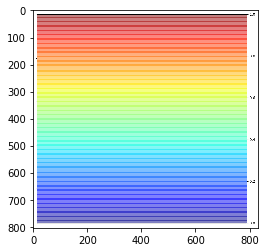

=========./Logs/flair/concept_identification/conv2d_13/node_1.png========


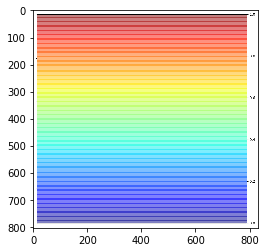

=========./Logs/flair/concept_identification/conv2d_13/node_0.png========


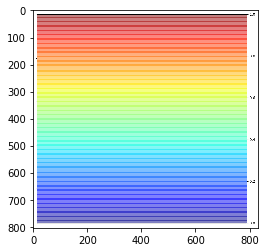

=========./Logs/flair/concept_identification/conv2d_19/node_13.png========


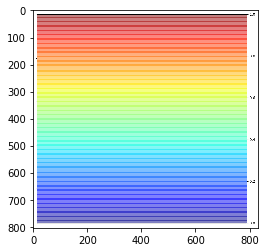

=========./Logs/flair/concept_identification/conv2d_19/node_10.png========


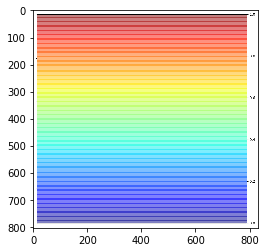

=========./Logs/flair/concept_identification/conv2d_19/node_11.png========


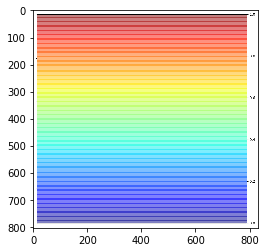

=========./Logs/flair/concept_identification/conv2d_19/node_14.png========


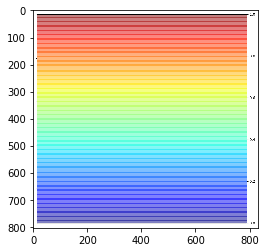

=========./Logs/flair/concept_identification/conv2d_19/node_12.png========


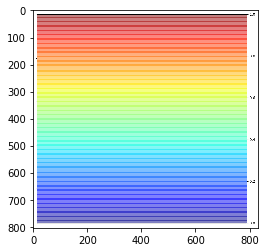

In [9]:
from glob import glob
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

save_root = './Logs/{}/concept_identification'.format(seq)
paths = np.array([pth for pth in glob(save_root + '/*/*.png') if not pth.__contains__('robustness')])
for pth in paths:
    print ("========={}========".format(pth))
    plt.imshow(np.array(Image.open(pth)))
    plt.show()


=========./Logs/flair/concept_identification/conv2d_13/node_2_robustness.png========


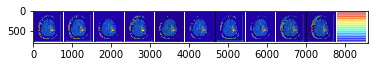

=========./Logs/flair/concept_identification/conv2d_13/node_1_robustness.png========


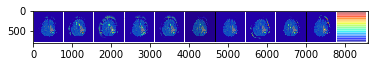

=========./Logs/flair/concept_identification/conv2d_13/node_0_robustness.png========


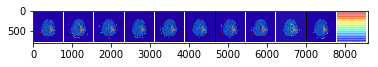

=========./Logs/flair/concept_identification/conv2d_19/node_11_robustness.png========


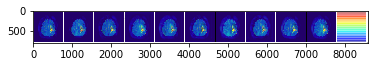

=========./Logs/flair/concept_identification/conv2d_19/node_12_robustness.png========


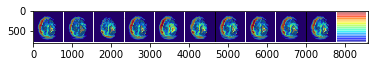

=========./Logs/flair/concept_identification/conv2d_19/node_10_robustness.png========


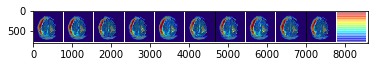

=========./Logs/flair/concept_identification/conv2d_19/node_13_robustness.png========


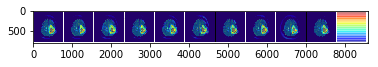

In [10]:
# Concept Robustness results

from glob import glob
from PIL import Image
import matplotlib
%matplotlib inline
import matplotlib.pyplot as plt

save_root = './Logs/{}/concept_identification'.format(seq)
paths = np.array([pth for pth in glob(save_root + '/*/*.png') if pth.__contains__('robustness')])
for pth in paths:
    print ("========={}========".format(pth))
    plt.imshow(np.array(Image.open(pth)))
    plt.show()

In [7]:
# These descriptions are provided manually by the user, 
# based on the way he/she interprets above images
# In this case we use atlas to obtain proper description


from pprint import pprint
consider_nodes = [{'node': 14, 'description': 'Lateral right hemispherical brain boundary'}, 
                  {'node': 19, 'description': 'Lateral left hemispherical brain boundary'}, 
                  {'node': 20, 'description': 'Anterior tumor region along with medial mid brain region'},
                  {'node': 21, 'description': 'Left lateral tumor region'},
                  {'node': 28, 'description': 'Eroded tumor core region'},
                  {'node': 35, 'description': 'Dilated tumor core region'},
                  {'node': 25, 'description': 'Anterior tumor region along with Lateral left hemispherical brain boundary'},
                  {'node': 29, 'description': 'Tumor core boundary along with Lateral left hemispherical brain boundary'},
                  {'node': 30, 'description': 'Whole tumor boundary and edima region'},
                  {'node': 4, 'description': 'Concave edge detector'},
                  {'node': 5, 'description': 'Convex edge deector'},
                  {'node': 6, 'description': 'Horizontal edge detectors'},
                  {'node': 10, 'description': 'Tumor Corner keypoints'},
                  {'node': 8, 'description': 'Corner keypoints all over the brain'},
                  {'node': 9, 'description': 'Corner keypoints in the tumor hemisphere brain'},
                  {'node': 13, 'description': 'Anterior brain boundary and inner brain corner keypoints'},
                ]

# update cluster info
save_root = './Logs/{}/weights_cluster/'.format(seq)
with open(os.path.join(save_root, 'cluster_info.cpickle'), 'rb') as file:
    concepts_info = pickle.load(file)
    
modified_concepts = []
for concept_info in concepts_info:
    for i, node in enumerate(consider_nodes):
        if node['node'] == int(concept_info['concept_name'].split('_').pop()):
            concept_info['description'] = consider_nodes[i]['description']
            pprint(concept_info)
            modified_concepts.append(concept_info)
            break

with open('./Logs/{}/modified_clusters.cpickle'.format(seq), 'wb') as file:
    pickle.dump(modified_concepts, file)  

{'concept_name': 'node_4',
 'description': 'Concave edge detector',
 'filter_idxs': array([  0,   3,   4,  10,  12,  13,  16,  20,  29,  30,  33,  34,  39,
        42,  44,  49,  59,  63,  64,  66,  71,  75,  77,  85,  89,  90,
        94,  96, 109, 112, 117, 118]),
 'layer_name': 'conv2d_5'}
{'concept_name': 'node_5',
 'description': 'Convex edge deector',
 'filter_idxs': array([  5,   7,  25,  32,  40,  50,  81, 111, 115, 116]),
 'layer_name': 'conv2d_5'}
{'concept_name': 'node_6',
 'description': 'Horizontal edge detectors',
 'filter_idxs': array([ 22,  26,  27,  28,  45,  57,  61,  65,  74,  82,  91,  98,  99,
       101, 107, 125]),
 'layer_name': 'conv2d_5'}
{'concept_name': 'node_8',
 'description': 'Corner keypoints all over the brain',
 'filter_idxs': array([  0,   5,   6,  14,  15,  28,  35,  36,  40,  45,  47,  51,  52,
        53,  61,  62,  65,  73,  74,  76,  77,  78,  85,  86,  91,  97,
        98, 108, 112, 116, 118, 122, 123, 139, 140, 142, 143, 150, 152,
       153, 1

----------

### Causal Graph Links


![causallinkage](./imgs/causality_linkage.png)

Any deep learning models are inherently correlation-based; they try to map an input to output \cite{}. By constraining the network accordingly, we can try to estimate hidden causal links responsible for feature map activations. In this step, we try to estimate links between the significant concepts formed in the above steps. These links capture causal interactions between the concepts. 

To construct this graph, we work with feature map distributions; mathematically, the link between two concept nodes exists if $MI$ (Mutual Information) between the feature map distributions is higher than a threshold value, described in bellow equations.

Let, $C_i^l$ denotes the $i^{th}$ concept in layer $l$. The directed link $C_i^p \rightarrow C_j^q$ is determined by $MI(\mathbb{Q}(x~|~\Phi_{j,q}), \mathbb{Q}(x~|~\Phi_{q}))$, where $\mathbb{Q}$ is the distribution of feature maps obtained by considering network $\Phi$. $\mathbb{Q}(x~|~\Phi_{j,q})$ is the distribution of feature maps generated as a result of considering just single concept $C_j^q$, while $\mathbb{Q}(x~|~\Phi_{q})$ is the distribution generated by considering all the concepts in layer $q$ and setting all $C_{-i}^p$ to zeros.

The directed link $C_i^p \rightarrow C_j^q$, exists only if $MI(\mathbb{Q}(x~|~\Phi_{j,q}), \mathbb{Q}(x~|~\Phi_{q})) > T$, i.e., the information between post-interventional distribution and pre-interventional distribution is higher than a threshold value. Equation \ref{} describes the same.

$$MI(C_j^q, ~do(C_i^p = 1) ~|~ do(C_{-i}^p = 0), ~do(C_{-j}^q = 0)) - MI(C_j^q, ~do(C_i^p = 0) ~|~ do(C_{-i}^p = 0), ~do(C_{-j}^q = 0)) > T$$
$$\Rightarrow MI(C_j^q, ~do(C_i^p = 1) ~|~ do(C_{-i}^p = 0), ~do(C_{-j}^q = 0)) > T$$


In [6]:
from BioExp.graphs.causal import CausalGraph
from BioExp.helpers import utils

metric = dice_label_coef # defined in helpers.losses
CG = CausalGraph(model, weights_path, metric)


with open('./Logs/{}/modified_clusters.cpickle'.format(seq), 'rb') as file:
    concept_info = pickle.load(file)

dataset_path = '../BioExp/sample_vol/brats/'
def dataloader(nslice = 78):
    def loader(img_path):
        image, gt =  utils.load_vol_brats(img_path, slicen=nslice)
        return image[:, :, seq_map[seq]][:,:, None], gt
    return loader

save_path = './Logs/{}/Graphs/causal'.format(seq)
os.makedirs(save_path, exist_ok=True)
CG.generate_graph(concept_info, 
                  dataset_path, 
                  dataloader(), 
                  edge_threshold = 0.25, 
                  save_path = save_path, 
                  max_samples=10)


[INFO: BioExp Graphs] Causal Relation between: node_4, node_8; edge weights: 0.2585625426335418
[INFO: BioExp Graphs] Causal Relation between: node_4, node_9; edge weights: 0.23070511421585663
[INFO: BioExp Graphs] Causal Relation between: node_4, node_10; edge weights: 0.1552457702575578
[INFO: BioExp Graphs] Causal Relation between: node_4, node_13; edge weights: 0.3876641481532881
[INFO: BioExp Graphs] Causal Relation between: node_4, node_14; edge weights: 0.32884144578734686
[INFO: BioExp Graphs] Causal Relation between: node_4, node_19; edge weights: 0.25387767628232943
[INFO: BioExp Graphs] Causal Relation between: node_4, node_20; edge weights: 0.5143501056304425
[INFO: BioExp Graphs] Causal Relation between: node_4, node_21; edge weights: 0.2838356809643605
[INFO: BioExp Graphs] Causal Relation between: node_4, node_25; edge weights: 0.23121094210890053
[INFO: BioExp Graphs] Causal Relation between: node_4, node_28; edge weights: 0.16976193290469485
[INFO: BioExp Graphs] Caus

In [7]:
import pickle

graph_path = './Logs/{}/Graphs/causal/causal_graph.pickle'.format(seq)
with open(graph_path, 'rb') as file:
    graph_json = pickle.load(file)

root_node = graph_json['rootNode']
graph = graph_json['graph']

graph.print(root_node)

node: Input, children: ['node_4', 'node_5', 'node_6'], parents: []
node: node_4, children: ['node_8', 'node_13', 'node_14', 'node_19', 'node_20', 'node_21'], parents: ['Input']
node: node_5, children: ['node_8', 'node_13', 'node_14', 'node_19', 'node_20', 'node_21'], parents: ['Input']
node: node_6, children: ['node_8', 'node_13', 'node_14', 'node_19', 'node_20', 'node_21'], parents: ['Input']
node: node_8, children: ['node_13', 'node_14', 'node_19', 'node_20', 'node_21'], parents: ['node_4', 'node_5', 'node_6']
node: node_13, children: ['node_14', 'node_19', 'node_20', 'node_21'], parents: ['node_4', 'node_5', 'node_6', 'node_8']
node: node_14, children: ['node_19', 'node_20', 'node_21'], parents: ['node_4', 'node_5', 'node_6', 'node_8', 'node_13']
node: node_19, children: ['node_20', 'node_21'], parents: ['node_4', 'node_5', 'node_6', 'node_8', 'node_13', 'node_14']
node: node_20, children: [], parents: ['node_4', 'node_5', 'node_6', 'node_8', 'node_13', 'node_14', 'node_19']
node: n

## Trail Estimation

In case of deep learning network, the obtained concept graph is tree with depth $m$, where $m$ is number of layers specified by the user for interpretability. The trails are all the paths running from input to a pariticular leaf nodes used in an inference. The obtained trails encode the flow of concept level information used in making prediction.


In [12]:
from BioExp.graphs.trails import EstimateTrails
from BioExp.helpers import utils

image, gt = utils.load_vol_brats('../BioExp/sample_vol/brats/Brats18_CBICA_ASA_1', slicen=92)
image = image[:, :, seq_map[seq]][:,:, None]
    
metric = dice_label_coef # defined in helpers.losses
GT = EstimateTrails(model, weights_path, graph, root_node, metric)

save_path = './Logs/{}/Graphs/trails'.format(seq)
tr, td, V = GT.trails('Input', 'node_22', image, gt, save_path=save_path, visual=True)


[INFO: BioExp Concept Identification] Identified Concept node_0 in layer conv2d_13
[INFO: BioExp Concept Identification] Identified Concept node_6 in layer conv2d_15
[INFO: BioExp Concept Identification] Identified Concept node_11 in layer conv2d_17
[INFO: BioExp Concept Identification] Identified Concept node_22 in layer conv2d_20
[INFO: BioExp Trails]===== New trail =====
  (Input)  ->  (node_0)  ->  (node_6)  ->  (node_11)  ->  (node_22)  
  (Input Image to a network)  ->  (Left Lower Brain boundary)  ->  (Brain boundary and tumor core)  ->  (Brain boundary and tumor core)  ->  (Tuomr core boundary (fine))  


# references

do-Calculus
+ https://ftp.cs.ucla.edu/pub/stat_ser/r402.pdf
+ https://plato.stanford.edu/entries/causal-models/do-calculus.html
+ https://arxiv.org/pdf/1305.5506.pdf

Graphs
+ KF ch1 to ch3

In [10]:
def calc_MI(X,Y,bins):

    c_XY = np.histogram2d(X,Y,bins)[0]
    c_X = np.histogram(X,bins)[0]
    c_Y = np.histogram(Y,bins)[0]

    H_X = shan_entropy(c_X)
    H_Y = shan_entropy(c_Y)
    H_XY = shan_entropy(c_XY)

    MI = H_X + H_Y - H_XY
    return 2.*MI/(H_X + H_Y)

def shan_entropy(c):
    c_normalized = c / float(np.sum(c))
    c_normalized = c_normalized[np.nonzero(c_normalized)]
    H = -sum(c_normalized* np.log2(c_normalized))  
    return H

def MI(distA, distB, bins=100, random=100):
    """
    """
    x = distA.reshape(distA.shape[0], -1)
    y = distB.reshape(distB.shape[0], -1)

    idxs = np.arange(x.shape[-1])
    if random:
        idxs = np.random.choice(idxs, random)

    mi = []
    for i in idxs:
        mi.append(calc_MI(x[:, i], y[:,i], bins))
    return np.mean(mi)


x = np.random.randn(10, 32,32,64)
y = np.random.randn(10, 32,32,64)

MI(x, y)

0.974525981954718

In [18]:
import numpy as np
shape = (5, 5, 32)
X = np.linspace(1, shape[0], shape[0])
Y = np.linspace(1, shape[1], shape[1])
Z = np.linspace(1, shape[2], shape[2])

X, Y, Z = np.meshgrid(X,Y,Z, indexing='ij')

In [13]:
assert (2,2)==(2,2)